<a href="https://colab.research.google.com/github/AdamFulton/teachinglol/blob/main/Image_Classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as f
import matplotlib.pyplot as plt
import os
import tarfile
from torchvision.utils import make_grid
from torchvision import models
from PIL import Image



In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])


dataset = CIFAR100(root="/data", download=True,transform=preprocess)
model = models.mobilenet_v3_large(pretrained=False)
model.classifier[3].out_features = 100

print(dataset[0][0].shape)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /data/cifar-100-python.tar.gz to /data
torch.Size([3, 224, 224])


In [ ]:
def split_indices(n ,val_pct):

  n_val = int(val_pct*n)
  idxs = np.random.permutation(n)

  return idxs[n_val:], idxs[:n_val]

In [ ]:
val_pct = 0.2
train_indices, val_indices = split_indices(len(dataset), val_pct)
print(len(train_indices), len(val_indices))
print('sample val indices: ', val_indices[:20])

40000 10000
sample val indices:  [20919 18728  7063 49431 11828 39133 47473 16449 41538 23293 36354 36888
 41057 41887 10513 22387 31846 16889 15160 34226]


In [ ]:
batch_size=32

train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,batch_size,sampler=train_sampler)

valid_sampler = SubsetRandomSampler(val_indices)
valid_dl = DataLoader(dataset,batch_size,sampler=valid_sampler)

In [ ]:
def show_batch(dl):

  for images,labels in dl:

    fig,ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images,10).permute(1,2,0))
    break

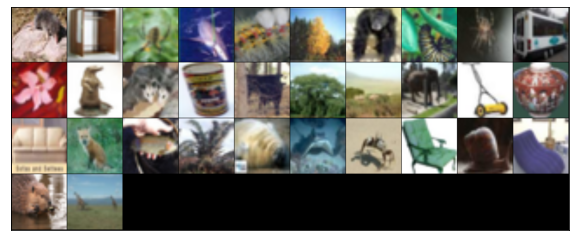

In [ ]:
show_batch(train_dl)

In [ ]:


for images,labels in train_dl:
  out = model(images)
  print(labels.shape)
  break

torch.Size([32])


In [ ]:
def get_default_device():

  if torch.cuda.is_available():
    return torch.device("cuda")

  else:
    return torch.device("cpu")
    

In [ ]:
device = get_default_device();
device

device(type='cuda')

In [ ]:
def to_device(data,device):

  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]

  return data.to(device,non_blocking=True)

In [ ]:
for images,labels in train_dl:
  print(images.shape)
  images = to_device(images,device)
  print(images.device)
  break

torch.Size([32, 3, 224, 224])
cuda:0


In [ ]:
class DeviceDataLoader():
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
       
        return len(self.dl)

In [ ]:
train_dl  = DeviceDataLoader(train_dl,device)
valid_dl = DeviceDataLoader(valid_dl,device)

to_device(model,device)

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False

In [ ]:
def loss_batch(model,loss_func,xb,yb,opt=None,metric=None):


    xb = xb.float()
    preds = model(xb)
    loss = loss_func(preds,yb)
   
    
    if opt is not None:
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    
    metric_result = None
    
    if metric is not None:
        metric_result = metric(preds,yb)
        
        
    
    return loss.item(),len(xb),metric_result

In [ ]:
def accuracy(outputs,labels):
    _, preds = torch.max(outputs,dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [ ]:
def evaluate(model,loss_fn,valid_dl,metric=None):
    with torch.no_grad():
        results = [loss_batch(model,loss_fn,xb,yb,metric=metric) for xb,yb in valid_dl]
        losses,nums,metrics = zip(*results)
        total = np.sum(nums)
        
        avg_loss = np.sum(np.multiply(losses,nums)) / total
        avg_metric = None
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics,nums)) / total
            
        
    return avg_loss,total,avg_metric

In [ ]:
def fit(epochs,model,loss_fn,train_dl,valid_dl,opt_fn=None,lr=None,metric=None):

  train_losses, val_losses,val_metrics = [],[],[]

  if opt_fn is None: opt_fn = torch.optim.Adam
  opt = opt_fn(model.parameters(),lr=lr)

  for epoch in range(epochs):

    model.train()
    for xb,yb in train_dl:

      train_loss,_,_= loss_batch(model,loss_fn,xb,yb,opt)

    
    model.eval()
    result = evaluate(model,loss_fn,valid_dl,metric)
    val_loss,total,val_metric = result

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_metrics.append(val_metric)

    if metric is None:
            print('Epoch [{}/{}],train_loss: {:.4f},val_loss: {:.4f} '
            .format(epoch+1,epochs,train_loss,val_loss))
    else:
      print('Epoch[{}/{}],train_Loss: {:.4f} ,val_Loss: {:.4f}, {}: {:.4f}'
            .format(epoch+1,epochs,train_loss,val_loss,metric.__name__,val_metric))
      

  return train_losses,val_losses,val_metrics

In [ ]:
val_loss, _,val_acc =evaluate(model,nn.CrossEntropyLoss(),valid_dl,metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss,val_acc))

torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size(

In [ ]:
num_epochs = 1

opt_fn = torch.optim.Adam
lr = 0.01

In [ ]:
history = fit(num_epochs,model, f.cross_entropy,train_dl,valid_dl,opt_fn,lr,accuracy)

train_losses,val_losses,val_metric = history

torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size([32, 1000])
torch.Size(

KeyboardInterrupt: ignored